<a href="https://colab.research.google.com/github/smannan/HumanActivityRecognitionLSTM/blob/main/HumanActivityRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# set up access to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme()
import tensorflow as tf

from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout, Conv2D, Conv1D, Bidirectional

In [ ]:
# Inertial Signals has the raw accelerometer and gyroscope readings
# whereas train / test txt have feature engineered vectors from the readings 
TRAIN_DIR = '/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/UCI_HAR_Dataset/train/'
TEST_DIR = '/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/UCI_HAR_Dataset/test/'

# researchers measured acceleration: total and body (estimated), as well as gyroscope (rotational velocity)
# measurements were taken every 2.56 seconds over a sliding window for 128 measurements per reading
MEASUREMENTS = ['total_acc', 'body_gyro', 'body_acc']
# measurements are taken in 3-dimensions: x, y, and z
DIMENSIONS = ['x', 'y', 'z']

# Hyperparameters
N_UNITS = 150
DROPOUT = 0.75
EPOCHS = 512
BATCH_SIZE = 64

N_TRAINING_SAMPLES = 7352
LABELS_TO_ACTIVITIES = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

## Prepare data for Modeling

In [ ]:
def load_data(train=True):
  dataset = []

  base_dir = TRAIN_DIR
  suffix = 'train'

  if not train:
    base_dir = TEST_DIR
    suffix = 'test'

  for measurement in MEASUREMENTS:
    for dimension in DIMENSIONS:
      feature_filename = '{0}/Inertial Signals/{1}_{2}_{3}.txt'.format(base_dir, measurement, dimension, suffix)
      print ('Loading {0}...'.format(feature_filename))

      feature_vector = pd.read_csv(feature_filename, header=None, delim_whitespace=True).to_numpy()
      print (feature_vector.shape)

      dataset.append(feature_vector)

  # a list of 9, [N x 128] feature vectors where N = number of samples in the data
  # stack according to the 3rd dim - 9, such that each resulting row is a 
  # 128 x 9 feature vector with measurements at each timestep
  dataset = np.dstack(dataset)
  print (dataset.shape)

  return dataset

In [ ]:
def load_labels(train=True):
  base_dir = TRAIN_DIR
  suffix = 'train'

  if not train:
    base_dir = TEST_DIR
    suffix = 'test'

  label_filename = '{0}/y_{1}.txt'.format(base_dir, suffix)
  print ('Loading {0}...'.format(label_filename))

  labels = pd.read_csv(label_filename, header=None, delim_whitespace=True).to_numpy()
  labels = labels.reshape(labels.shape[0])
  print ('Labels shape {0}'.format(labels.shape))

  # one-hot encode the labels to get multi-class probabilities for each prediction
  labels = labels - 1
  labels_one_hot = to_categorical(labels, 6)
  print ('Labels one hot encoded {0}'.format(labels_one_hot.shape))
  
  return labels_one_hot

In [ ]:
def prepare_data():
  return load_data(), load_labels(), load_data(train=False), load_labels(train=False)

In [ ]:
X_train, y_train, X_test, y_test = prepare_data()

In [ ]:
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [ ]:
def normalize_data(data):
  data_norm = []
  for row in data:
    data_norm.append(normalize(row, norm='l2', axis=0))
  return np.array(data_norm)

In [ ]:
def plot_confusion_matrix(y_truth, preds):
  cm = confusion_matrix(y_truth, preds)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  tick_marks = np.arange(len(LABELS_TO_ACTIVITIES))
  plt.yticks(tick_marks, LABELS_TO_ACTIVITIES)
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

  return plt

## LSTM model with one hidden layer

Training time: ~1 seconds / epoch

1. LSTM 50, 150, 100 units
- 64 epochs = 85.51%, 84.05%, 85.48%
- 128 epochs = 85.41%, 89.14%, 87.99%

2. LSTM different epochs, 150 units
- 15 epochs: 72.66%
- 64 epochs: 87.38%
- 128 epochs: 86.80%
- 256 epochs: 88.80%
- 512 epochs: 89.14%

3. LSTM different dropout levels (150 units, 512 epochs)
- No Dropout = 87.11%
- 75% Dropout = 89.38%
- 95% Dropout = 58.36%

4. Normalize data (150 units, 512 epochs, dropout 0.75) = 82.2%

In [ ]:
def define_lstm_one_layer_model(n_timesteps, n_features, n_outputs):
  model = Sequential()
  model.add(LSTM(N_UNITS, input_shape=(n_timesteps, n_features)))
  model.add(Dropout(DROPOUT))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  return model

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [ ]:
one_layer_lstm = define_lstm_one_layer_model(n_timesteps, n_features, n_outputs)

In [ ]:
epochs, batch_size = EPOCHS, BATCH_SIZE
one_layer_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#one_layer_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.7)
one_layer_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               96000     
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               15100     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 111,706
Trainable params: 111,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
_, accuracy = one_layer_lstm.evaluate(X_test, y_test, batch_size=batch_size)

47/47 [==============================] - 0s 5ms/step - loss: 1.2887 - accuracy: 0.8887


## LSTM Model Multiple Hidden Layers

1. Number of Hidden Layers (512 epochs, 0.75 dropout, 150 units)
- 4 layers: 87.31%
- 5 layers: 89.07%
- 8 layers: 85.92%

In [ ]:
def define_lstm_multi_layer_model(n_timesteps, n_features, n_outputs, n_lstms=4):
  model = Sequential()
  model.add(Dense(9, activation='relu'))
  
  model.add(LSTM(N_UNITS, input_shape=(n_timesteps, n_features), return_sequences=True))

  for i in range(n_lstms-2):
    model.add(LSTM(N_UNITS, return_sequences=True))
  
  model.add(LSTM(N_UNITS))
  model.add(Dropout(DROPOUT))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  return model

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
multi_layer_lstm = define_lstm_multi_layer_model(n_timesteps, n_features, n_outputs, n_lstms=4)

epochs, batch_size = EPOCHS, BATCH_SIZE
optimizer = Adam(lr=0.0025)
multi_layer_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
multi_layer_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.7)

In [ ]:
_, accuracy = multi_layer_lstm.evaluate(X_test, y_test, batch_size=batch_size)

47/47 [==============================] - 1s 13ms/step - loss: 1.4469 - accuracy: 0.9050


In [ ]:
multi_layer_lstm.save('/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/multi_layer_lstm')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/multi_layer_lstm/assets


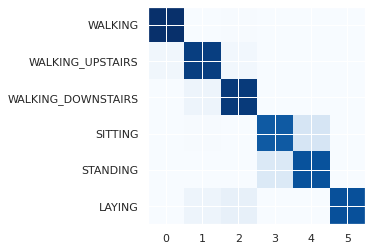

In [ ]:
multi_layer_lstm = keras.models.load_model('/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/multi_layer_lstm')
preds = multi_layer_lstm.predict(X_test)
preds = np.array([np.argmax(pred) for pred in preds])
y_truth = np.array([np.argmax(test) for test in y_test])
cm_plot = plot_confusion_matrix(y_truth, preds)
cm_plot.savefig('/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/multi_layer_lstm_cmap.png', bbox_inches='tight')

In [ ]:
multi_layer_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0025), metrics=['accuracy'])
multi_layer_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128, 100)          1000      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 150)          150600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 150)          180600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128, 150)          180600    
_________________________________________________________________
lstm_4 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)              

## BiRNN

1. @128 epochs with 3 hidden LSTM layers = 87.04% accurate
2. @128 epochs with 1 hidden LSTM layer = 87.48% accurate


In [ ]:
def define_lstm_birnn_layer_model(n_timesteps, n_features, n_outputs):
  model = Sequential()
  model.add(Bidirectional(LSTM(N_UNITS, input_shape=(n_timesteps, n_features))))
  model.add(Dropout(DROPOUT))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  return model

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
birnn_lstm = define_lstm_birnn_layer_model(n_timesteps, n_features, n_outputs)

epochs, batch_size = EPOCHS, BATCH_SIZE
optimizer = Adam(lr=0.0025)
birnn_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
birnn_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.7)

In [ ]:
_, accuracy = birnn_lstm.evaluate(X_test, y_test, batch_size=batch_size)

47/47 [==============================] - 0s 7ms/step - loss: 1.5082 - accuracy: 0.8663


In [ ]:
birnn_lstm.save('/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/birnn_lstm')

INFO:tensorflow:Assets written to: /content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/birnn_lstm/assets


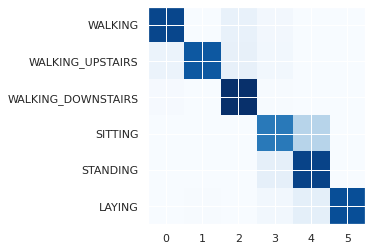

In [ ]:
preds = birnn_lstm.predict(X_test)
preds = np.array([np.argmax(pred) for pred in preds])
y_truth = np.array([np.argmax(test) for test in y_test])
cm_plot = plot_confusion_matrix(y_truth, preds)
cm_plot.savefig('/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/bi_rnn_lstm_cmap.png', bbox_inches='tight')

In [ ]:
bi_lstm = keras.models.load_model('/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/birnn_lstm')
bi_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0025), metrics=['accuracy'])
bi_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 300)               192000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 606       
Total params: 222,706
Trainable params: 222,706
Non-trainable params: 0
_________________________________________________________________


## Visualize time series data

In [ ]:
dataset = []

for measurement in MEASUREMENTS:
  for dimension in DIMENSIONS:
    feature_filename = '{0}/Inertial Signals/{1}_{2}_{3}.txt'.format(TRAIN_DIR, measurement, dimension, 'train')
    print ('Loading {0}...'.format(feature_filename))

    feature_vector = pd.read_csv(feature_filename, header=None, delim_whitespace=True).to_numpy()
    print (feature_vector.shape)

    dataset.append(feature_vector)

Loading /content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/UCI_HAR_Dataset/train//Inertial Signals/total_acc_x_train.txt...
(7352, 128)
Loading /content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/UCI_HAR_Dataset/train//Inertial Signals/total_acc_y_train.txt...
(7352, 128)
Loading /content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/UCI_HAR_Dataset/train//Inertial Signals/total_acc_z_train.txt...
(7352, 128)
Loading /content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/UCI_HAR_Dataset/train//Inertial Signals/body_gyro_x_train.txt...
(7352, 128)
Loading /content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/UCI_HAR_Dataset/train//Inertial Signals/body_gyro_y_train.txt...
(7352, 128)
Loading /content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/UCI_HAR_Dataset/train//Inertial Signals/body_gyro_z_train.txt...
(7352, 128)
Loading /content/drive/My Drive/CMPE258_Deep_Learning/HumanActiv

In [ ]:
label_filename = '{0}/y_{1}.txt'.format(TRAIN_DIR, 'train')
ylabels = pd.read_csv(label_filename, header=None, delim_whitespace=True).to_numpy()

In [ ]:
def plot_measurements_for_sample(dataset, ylabels, target=5):
  indices = np.argwhere(ylabels == target)
  random_sample = indices[np.random.choice(len(indices), 1)[0]][0]
  measurement_labels = ['total_acc_x', 'total_acc_y', 'total_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'body_acc_x', 'body_acc_y', 'body_acc_z']

  for i in range(len(measurement_labels)):
    plt.plot(dataset[i][random_sample], label=measurement_labels[i])

  plt.title('{0} Measurements for Sample {1}'.format(LABELS_TO_ACTIVITIES[ylabels[random_sample][0]-1], random_sample))
  plt.xlabel('Timestep')
  plt.ylabel('Measurement')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Measurement Type')
  return plt

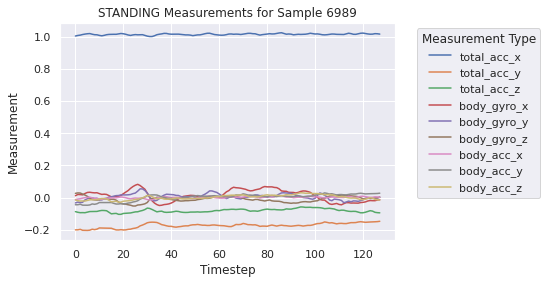

In [ ]:
plt = plot_measurements_for_sample(dataset, ylabels)
plt.savefig('/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/standing_single_viz', bbox_inches='tight')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

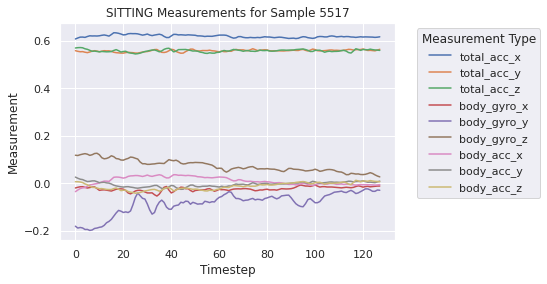

In [ ]:
plot_measurements_for_sample(dataset, ylabels, target=LABELS_TO_ACTIVITIES.index('SITTING')+1)

In [ ]:
def plot_histogram(ylabels):
  # An "interface" to matplotlib.axes.Axes.hist() method
  n, bins, patches = plt.hist(x=ylabels.flatten().tolist(), bins='auto', color='#0504aa',
                              alpha=0.7, rwidth=0.85)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('Activity')
  plt.ylabel('Frequency')
  plt.title('Activity Frequency in Dataset')
  maxfreq = n.max()
  # Set a clean upper y-axis limit.
  plt.ylim(ymax=np.ceil(maxfreq / 10) * 12 if maxfreq % 10 else maxfreq + 10)
  return plt

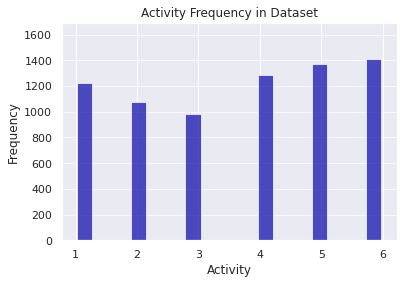

In [ ]:
plt = plot_histogram(ylabels)
plt.savefig('/content/drive/My Drive/CMPE258_Deep_Learning/HumanActivityRecognition/label_dist', bbox_inches='tight')